Анализ продаж: от ETL до инсайтов

In [57]:
# 1. ИМПОРТ БИБЛИОТЕК
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os

# Визуализация
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import plot

# Машинное обучение (для кластеризации в RFM)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer
from sklearn.preprocessing import FunctionTransformer

In [37]:
# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [62]:
'''1. Загрузка данных'''
data = pd.read_csv('merged_sales_data.csv')

In [42]:
'''Просмотр первых 5 строк'''
print("Исходные данные:")
print(data.head())

Исходные данные:
   ProductKey   OrderDate    ShipDate  CustomerKey  PromotionKey  \
0         310  2014-01-01  2014-01-08        21768             1   
1         346  2014-01-01  2014-01-08        28389             1   
2         346  2014-01-01  2014-01-08        25863             1   
3         336  2014-01-01  2014-01-08        14501             1   
4         346  2014-01-01  2014-01-08        11003             1   

   SalesTerritoryKey SalesOrderNumber  SalesOrderLineNumber  OrderQuantity  \
0                  6          SO43697                     1              2   
1                  7          SO43698                     1              2   
2                  1          SO43699                     1              2   
3                  4          SO43700                     1              2   
4                  9          SO43701                     1              2   

   UnitPrice  TotalProductCost  SalesAmount    TaxAmt FirstName  LastName  \
0  1789.1350         2171.29

In [63]:
'''5. Печать информации о очищенных данных'''
print("\nИнформация об очищенных данных:")
print(data.info())


Информация об очищенных данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58189 entries, 0 to 58188
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProductKey            58189 non-null  int64  
 1   OrderDate             58189 non-null  object 
 2   ShipDate              58189 non-null  object 
 3   CustomerKey           58189 non-null  int64  
 4   PromotionKey          58189 non-null  int64  
 5   SalesTerritoryKey     58189 non-null  int64  
 6   SalesOrderNumber      58189 non-null  object 
 7   SalesOrderLineNumber  58189 non-null  int64  
 8   OrderQuantity         58189 non-null  int64  
 9   UnitPrice             58189 non-null  float64
 10  TotalProductCost      58189 non-null  float64
 11  SalesAmount           58189 non-null  float64
 12  TaxAmt                58189 non-null  float64
 13  FirstName             58189 non-null  object 
 14  LastName              58189 non-null 

In [64]:
'''1. Обработка пропусков'''
'''Печатаем количество пропущенных значений в каждом столбце'''
print("\nКоличество пропущенных значений:")
print(data.isnull().sum())


Количество пропущенных значений:
ProductKey                  0
OrderDate                   0
ShipDate                    0
CustomerKey                 0
PromotionKey                0
SalesTerritoryKey           0
SalesOrderNumber            0
SalesOrderLineNumber        0
OrderQuantity               0
UnitPrice                   0
TotalProductCost            0
SalesAmount                 0
TaxAmt                      0
FirstName                   0
LastName                    0
FullName                    0
BirthDate                   0
MaritalStatus               0
Gender                      0
YearlyIncome                0
TotalChildren               0
NumberChildrenAtHome        0
Education                   0
Occupation                  0
HouseOwnerFlag              0
NumberCarsOwned             0
AddressLine1                0
DateFirstPurchase           0
CommuteDistance             0
CustomerCity                0
CustomerStateCode           0
CustomerState               0
Custom

In [65]:
'''Удаление строк с пропущенными значениями'''
data_cleaned = data.dropna()

In [66]:
'''2. Удаление дубликатов'''
duplicates_count = data_cleaned.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates_count}")
data_cleaned = data_cleaned.drop_duplicates()


Количество дубликатов: 0


In [68]:
'''3. Приведение типов'''
'''Приведение столбца 'BirthDate' к типу datetime'''
data_cleaned['OrderDate'] = pd.to_datetime(data_cleaned['OrderDate'], errors='coerce')
data_cleaned['ShipDate'] = pd.to_datetime(data_cleaned['ShipDate'], errors='coerce')
data_cleaned['BirthDate'] = pd.to_datetime(data_cleaned['BirthDate'], errors='coerce')

In [69]:
'''Просмотр первых 5 строк'''
print("Исходные данные:")
print(data.head())

Исходные данные:
   ProductKey   OrderDate    ShipDate  CustomerKey  PromotionKey  \
0         310  2014-01-01  2014-01-08        21768             1   
1         346  2014-01-01  2014-01-08        28389             1   
2         346  2014-01-01  2014-01-08        25863             1   
3         336  2014-01-01  2014-01-08        14501             1   
4         346  2014-01-01  2014-01-08        11003             1   

   SalesTerritoryKey SalesOrderNumber  SalesOrderLineNumber  OrderQuantity  \
0                  6          SO43697                     1              2   
1                  7          SO43698                     1              2   
2                  1          SO43699                     1              2   
3                  4          SO43700                     1              2   
4                  9          SO43701                     1              2   

   UnitPrice  TotalProductCost  SalesAmount    TaxAmt FirstName  LastName  \
0  1789.1350         2171.29

In [70]:
'''5. Печать информации о очищенных данных'''
print("\nИнформация об очищенных данных:")
print(data_cleaned.info())


Информация об очищенных данных:
<class 'pandas.core.frame.DataFrame'>
Index: 30747 entries, 0 to 58188
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            30747 non-null  int64         
 1   OrderDate             30747 non-null  datetime64[ns]
 2   ShipDate              30747 non-null  datetime64[ns]
 3   CustomerKey           30747 non-null  int64         
 4   PromotionKey          30747 non-null  int64         
 5   SalesTerritoryKey     30747 non-null  int64         
 6   SalesOrderNumber      30747 non-null  object        
 7   SalesOrderLineNumber  30747 non-null  int64         
 8   OrderQuantity         30747 non-null  int64         
 9   UnitPrice             30747 non-null  float64       
 10  TotalProductCost      30747 non-null  float64       
 11  SalesAmount           30747 non-null  float64       
 12  TaxAmt                30747 non-null  float64 

In [71]:
'''6. Сохранение очищенных данных'''
data_cleaned.to_csv('cleaned_data.csv', index=False)

print("Очистка данных завершена!")

Очистка данных завершена!


In [72]:
'''1. Загрузка данных'''
data = pd.read_csv('cleaned_data.csv')

In [ ]:
# '''1. Z-score Normalization'''
# z_score_scaler = StandardScaler()
# z_score_normalized = z_score_scaler.fit_transform(data)

'''2. Min-Max Normalization'''
min_max_scaler = MinMaxScaler()
min_max_normalized = min_max_scaler.fit_transform(data)

'''3. Robust Scaler'''
robust_scaler = RobustScaler()
robust_normalized = robust_scaler.fit_transform(data)

'''4. MaxAbs Scaler'''
max_abs_scaler = MaxAbsScaler()
max_abs_normalized = max_abs_scaler.fit_transform(data)

'''5. Log Transformation'''
log_transformer = FunctionTransformer(np.log1p, validate=True)
log_transformed = log_transformer.fit_transform(data)

'''6. Quantile Transformation'''
quantile_transformer = QuantileTransformer(output_distribution='uniform')
quantile_normalized = quantile_transformer.fit_transform(data)

'''7. Decimal Scaling'''
def decimal_scaling(data):
    j = np.ceil(np.log10(np.abs(data).max() + 1))
    return data / (10 ** j)

decimal_scaled = decimal_scaling(data)

'''8. Softmax Normalization'''
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=0)

softmax_normalized = softmax(data)

'''Вывод результатов'''
print("Z-score Normalized:\n", z_score_normalized)
print("Min-Max Normalized:\n", min_max_normalized)
print("Robust Normalized:\n", robust_normalized)
print("MaxAbs Normalized:\n", max_abs_normalized)
print("Log Transformed:\n", log_transformed)
print("Quantile Normalized:\n", quantile_normalized)
print("Decimal Scaled:\n", decimal_scaled)
print("Softmax Normalized:\n", softmax_normalized)

In [75]:
# Очистка пропусков (пример заполнения медианами и модами)
for column in data.columns:
    if data[column].dtype != object:
        median_value = data[column].median()
        data[column].fillna(median_value, inplace=True)
    else:
        mode_value = data[column].mode()[0]
        data[column].fillna(mode_value, inplace=True)

In [88]:
df = data

In [89]:
# 🧹 ОЧИСТКА И ПРЕОБРАЗОВАНИЕ ДАННЫХ
print("🧹 ОЧИСТКА ДАННЫХ")
print("=" * 50)
df = data
# Сохраняем исходный размер
initial_count = len(df)
print(f"📊 Исходное количество строк: {initial_count}")

# Удаление дубликатов
df = df.drop_duplicates()
duplicates_removed = initial_count - len(df)
print(f"📊 Удалено дубликатов: {duplicates_removed}")

# Анализ пропущенных значений
print("\n📊 АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_info = pd.DataFrame({
    'Количество': missing_data,
    'Процент': missing_percent
}).sort_values('Количество', ascending=False)

# Показываем только колонки с пропусками
missing_columns = missing_info[missing_info['Количество'] > 0]
if len(missing_columns) > 0:
    print("Колонки с пропущенными значениями:")
    display(missing_columns)
else:
    print("✅ Пропущенных значений не обнаружено")

# Заполнение пропусков для ключевых колонок
print("\n🔧 ЗАПОЛНЕНИЕ ПРОПУСКОВ:")
if 'Color' in df.columns:
    df['Color'] = df['Color'].fillna('Not Specified')
    print("✅ Color: заполнены пропуски значением 'Not Specified'")

if 'SubCategory' in df.columns:
    df['SubCategory'] = df['SubCategory'].fillna('Unknown')
    df['Category'] = df['Category'].fillna('Unknown')
    print("✅ Category/SubCategory: заполнены пропуски значением 'Unknown'")

# Преобразование типов данных
print("\n🔄 ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ:")

date_columns = ['OrderDate', 'ShipDate', 'BirthDate', 'DateFirstPurchase', 'StartDate']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"✅ {col}: преобразована в datetime")

# Преобразование числовых колонок
numeric_columns = ['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 
                  'NumberCarsOwned', 'StandardCost', 'ListPrice', 'DaysToManufacture',
                  'OrderQuantity', 'UnitPrice', 'TotalProductCost', 'SalesAmount', 'TaxAmt']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"✅ {col}: преобразована в числовой формат")

# Создание новых признаков
print("\n🎯 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ:")

if 'OrderDate' in df.columns:
    df['OrderYear'] = df['OrderDate'].dt.year
    df['OrderMonth'] = df['OrderDate'].dt.month
    df['OrderQuarter'] = df['OrderDate'].dt.quarter
    df['OrderDayOfWeek'] = df['OrderDate'].dt.day_name()
    print("✅ Созданы временные признаки из OrderDate")
    
    # Расчет времени доставки
    if 'ShipDate' in df.columns:
        df['DeliveryDays'] = (df['ShipDate'] - df['OrderDate']).dt.days
        print("✅ Создан признак DeliveryDays")

# Создание демографических сегментов
if 'YearlyIncome' in df.columns:
    df['IncomeSegment'] = pd.cut(df['YearlyIncome'], 
                               bins=[0, 50000, 80000, 100000, float('inf')],
                               labels=['Low', 'Medium', 'High', 'Very High'])
    print("✅ Создан IncomeSegment")

# Расчет возраста клиента
if 'BirthDate' in df.columns:
    df['Age'] = (datetime.now() - df['BirthDate']).dt.days // 365
    print("✅ Создан признак Age")

# Расчет прибыльности
if 'SalesAmount' in df.columns and 'TotalProductCost' in df.columns:
    df['Profit'] = df['SalesAmount'] - df['TotalProductCost']
    df['ProfitMargin'] = (df['Profit'] / df['SalesAmount']) * 100
    print("✅ Созданы Profit и ProfitMargin")

# Расчет общей суммы, если нет
if 'UnitPrice' in df.columns and 'OrderQuantity' in df.columns and 'TotalAmount' not in df.columns:
    df['TotalAmount'] = df['UnitPrice'] * df['OrderQuantity']
    print("✅ Создан TotalAmount")

print(f"\n📊 РЕЗУЛЬТАТ ОЧИСТКИ:")
print(f"   • Исходный размер: {initial_count} строк")
print(f"   • Финальный размер: {len(df)} строк") 
print(f"   • Удалено дубликатов: {duplicates_removed}")
print(f"   • Количество колонок: {len(df.columns)}")

print("\n👀 ПРЕВЬЮ ОЧИЩЕННЫХ ДАННЫХ:")
display(df.head(3))

print("\n📋 ИНФОРМАЦИЯ О ДАННЫХ ПОСЛЕ ОЧИСТКИ:")
print(df.info())

print("\n✅ ДАННЫЕ ОЧИЩЕНЫ И ПРЕОБРАЗОВАНЫ!")
'''6. Сохранение очищенных данных'''
data_cleaned.to_csv('cleaned_data.csv', index=False)

print("Очистка данных завершена!")

🧹 ОЧИСТКА ДАННЫХ
📊 Исходное количество строк: 30747
📊 Удалено дубликатов: 0

📊 АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:
✅ Пропущенных значений не обнаружено

🔧 ЗАПОЛНЕНИЕ ПРОПУСКОВ:
✅ Color: заполнены пропуски значением 'Not Specified'
✅ Category/SubCategory: заполнены пропуски значением 'Unknown'

🔄 ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ:
✅ OrderDate: преобразована в datetime
✅ ShipDate: преобразована в datetime
✅ BirthDate: преобразована в datetime
✅ DateFirstPurchase: преобразована в datetime
✅ StartDate: преобразована в datetime
✅ YearlyIncome: преобразована в числовой формат
✅ TotalChildren: преобразована в числовой формат
✅ NumberChildrenAtHome: преобразована в числовой формат
✅ NumberCarsOwned: преобразована в числовой формат
✅ StandardCost: преобразована в числовой формат
✅ ListPrice: преобразована в числовой формат
✅ DaysToManufacture: преобразована в числовой формат
✅ OrderQuantity: преобразована в числовой формат
✅ UnitPrice: преобразована в числовой формат
✅ TotalProductCost: преобразована в числ

,ProductKey,OrderDate,ShipDate,CustomerKey,PromotionKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,OrderQuantity,UnitPrice,TotalProductCost,SalesAmount,TaxAmt,FirstName,LastName,FullName,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,AddressLine1,DateFirstPurchase,CommuteDistance,CustomerCity,CustomerStateCode,CustomerState,CustomerCountry,ProductName,SubCategory,Category,StandardCost,Color,ListPrice,DaysToManufacture,ProductLine,ModelName,Photo,ProductDescription,StartDate,Region,Country,Group,RegionImage,Region Info,OrderYear,OrderMonth,OrderQuarter,OrderDayOfWeek,DeliveryDays,IncomeSegment,Age,Profit,ProfitMargin,TotalAmount
0,310,2014-01-01,2014-01-08,21768,1,6,SO43697,1,2,1789.135,2171.2942,3578.27,286.2616,Cole,Watson,"Watson, Cole",1946-08-22,S,M,70000,5,0,Bachelors,Management,1,3,601 Asilomar Dr.,2005-07-01,10+ Miles,Metchosin,BC,British Columbia,Canada,"Road-150 Red, 62",Road Bikes,Bikes,2171.2942,Red,3578.27,4,Road,Road-150,http://www.avising.com/me/LearnPBI/DataSources...,This bike is ridden by race winners. Developed...,2005-07-01,Canada,Canada,North America,http://www.avising.com/me/LearnPBI/DataSources...,https://en.wikipedia.org/wiki/Canada,2014,1,1,Wednesday,7,Medium,79,1406.9758,39.320001,3578.27
1,346,2014-01-01,2014-01-08,28389,1,7,SO43698,1,2,1699.995,1912.1544,3399.99,271.9992,Rachael,Martinez,"Martinez, Rachael",1964-12-18,S,F,20000,3,3,High School,Manual,0,0,"14, avenue du Port",2005-07-01,0-1 Miles,Pantin,93,Seine Saint Denis,France,"Mountain-100 Silver, 44",Mountain Bikes,Bikes,1912.1544,Silver,3399.99,4,Mountain,Mountain-100,http://www.avising.com/me/LearnPBI/DataSources...,Top-of-the-line competition mountain bike. Per...,2005-07-01,France,France,Europe,http://www.avising.com/me/LearnPBI/DataSources...,https://en.wikipedia.org/wiki/France,2014,1,1,Wednesday,7,Low,60,1487.8356,43.759999,3399.99
2,346,2014-01-01,2014-01-08,25863,1,1,SO43699,1,2,1699.995,1912.1544,3399.99,271.9992,Sydney,Wright,"Wright, Sydney",1946-12-03,S,F,40000,5,0,High School,Professional,1,3,4193 E. 28th Street,2005-07-01,10+ Miles,Lebanon,OR,Oregon,United States,"Mountain-100 Silver, 44",Mountain Bikes,Bikes,1912.1544,Silver,3399.99,4,Mountain,Mountain-100,http://www.avising.com/me/LearnPBI/DataSources...,Top-of-the-line competition mountain bike. Per...,2005-07-01,Northwest,United States,North America,http://www.avising.com/me/LearnPBI/DataSources...,https://en.wikipedia.org/wiki/Northwestern_Uni...,2014,1,1,Wednesday,7,Low,78,1487.8356,43.759999,3399.99



📋 ИНФОРМАЦИЯ О ДАННЫХ ПОСЛЕ ОЧИСТКИ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30747 entries, 0 to 30746
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            30747 non-null  int64         
 1   OrderDate             30747 non-null  datetime64[ns]
 2   ShipDate              30747 non-null  datetime64[ns]
 3   CustomerKey           30747 non-null  int64         
 4   PromotionKey          30747 non-null  int64         
 5   SalesTerritoryKey     30747 non-null  int64         
 6   SalesOrderNumber      30747 non-null  object        
 7   SalesOrderLineNumber  30747 non-null  int64         
 8   OrderQuantity         30747 non-null  int64         
 9   UnitPrice             30747 non-null  float64       
 10  TotalProductCost      30747 non-null  float64       
 11  SalesAmount           30747 non-null  float64       
 12  TaxAmt                30747 non-null

In [ ]:
# 🗑️ УДАЛЕНИЕ ЛИШНИХ СТОЛБЦОВ
print("🗑️ УДАЛЕНИЕ ЛИШНИХ СТОЛБЦОВ")
print("=" * 40)

# Список столбцов для удаления
columns_to_remove = [
    'Photo', 
    'NumberChildrenAtHome', 
    'AddressLine1', 
    'RegionImage', 
    'RegionInfo', 
    'CustomerStateCode', 
    'ProductDescription', 
    'SalesOrderLineNumber', 
    'StandardCost',  # равен TotalProductCost
    'ListPrice',     # равен SalesAmount  
    'PromotionKey',
    'CustomerCountry', # равен Country
    'Group'
]

print("📋 СТОЛБЦЫ ДЛЯ УДАЛЕНИЯ:")
for i, col in enumerate(columns_to_remove, 1):
    print(f"   {i:2d}. {col}")

# Удаляем только существующие столбцы
existing_columns_to_remove = [col for col in columns_to_remove if col in df.columns]
non_existing_columns = [col for col in columns_to_remove if col not in df.columns]

print(f"\n СТАТУС СТОЛБЦОВ:")
print(f"   ✅ Найдено для удаления: {len(existing_columns_to_remove)}")
print(f"   ❌ Не найдено в данных: {len(non_existing_columns)}")

if non_existing_columns:
    print("   📝 Отсутствующие столбцы:")
    for col in non_existing_columns:
        print(f"      - {col}")

# Сохраняем исходное количество столбцов
initial_columns_count = len(df.columns)
print(f"\n📊 ИСХОДНОЕ КОЛИЧЕСТВО СТОЛБЦОВ: {initial_columns_count}")

# Удаляем столбцы
df = df.drop(columns=existing_columns_to_remove, errors='ignore')

# Финальное количество столбцов
final_columns_count = len(df.columns)
columns_removed = initial_columns_count - final_columns_count

print(f"\n📊 РЕЗУЛЬТАТ УДАЛЕНИЯ:")
print(f"   • Удалено столбцов: {columns_removed}")
print(f"   • Осталось столбцов: {final_columns_count}")
print(f"   • Сокращение: {columns_removed}/{initial_columns_count} ({columns_removed/initial_columns_count*100:.1f}%)")

print(f"\n📝 ОСТАВШИЕСЯ СТОЛБЦЫ ({final_columns_count}):")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

print("\n👀 ПРЕВЬЮ ДАННЫХ ПОСЛЕ УДАЛЕНИЯ:")
display(df.head(2))

print("✅ ЛИШНИЕ СТОЛБЦЫ УДАЛЕНЫ!")

🗑️ УДАЛЕНИЕ ЛИШНИХ СТОЛБЦОВ
📋 СТОЛБЦЫ ДЛЯ УДАЛЕНИЯ:
    1. Photo
    2. NumberChildrenAtHome
    3. AddressLine1
    4. RegionImage
    5. RegionInfo
    6. CustomerStateCode
    7. ProductDescription
    8. SalesOrderLineNumber
    9. StandardCost
   10. ListPrice
   11. PromotionKey
   12. CustomerCountry
   13. Group

🔍 СТАТУС СТОЛБЦОВ:
   ✅ Найдено для удаления: 12
   ❌ Не найдено в данных: 1
   📝 Отсутствующие столбцы:
      - RegionInfo

📊 ИСХОДНОЕ КОЛИЧЕСТВО СТОЛБЦОВ: 60

📊 РЕЗУЛЬТАТ УДАЛЕНИЯ:
   • Удалено столбцов: 12
   • Осталось столбцов: 48
   • Сокращение: 12/60 (20.0%)

📝 ОСТАВШИЕСЯ СТОЛБЦЫ (48):
    1. ProductKey
    2. OrderDate
    3. ShipDate
    4. CustomerKey
    5. SalesTerritoryKey
    6. SalesOrderNumber
    7. OrderQuantity
    8. UnitPrice
    9. TotalProductCost
   10. SalesAmount
   11. TaxAmt
   12. FirstName
   13. LastName
   14. FullName
   15. BirthDate
   16. MaritalStatus
   17. Gender
   18. YearlyIncome
   19. TotalChildren
   20. Education
   21. Oc

,ProductKey,OrderDate,ShipDate,CustomerKey,SalesTerritoryKey,SalesOrderNumber,OrderQuantity,UnitPrice,TotalProductCost,SalesAmount,TaxAmt,FirstName,LastName,FullName,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,CustomerCity,CustomerState,ProductName,SubCategory,Category,Color,DaysToManufacture,ProductLine,ModelName,StartDate,Region,Country,Region Info,OrderYear,OrderMonth,OrderQuarter,OrderDayOfWeek,DeliveryDays,IncomeSegment,Age,Profit,ProfitMargin,TotalAmount
0,310,2014-01-01,2014-01-08,21768,6,SO43697,2,1789.135,2171.2942,3578.27,286.2616,Cole,Watson,"Watson, Cole",1946-08-22,S,M,70000,5,Bachelors,Management,1,3,2005-07-01,10+ Miles,Metchosin,British Columbia,"Road-150 Red, 62",Road Bikes,Bikes,Red,4,Road,Road-150,2005-07-01,Canada,Canada,https://en.wikipedia.org/wiki/Canada,2014,1,1,Wednesday,7,Medium,79,1406.9758,39.320001,3578.27
1,346,2014-01-01,2014-01-08,28389,7,SO43698,2,1699.995,1912.1544,3399.99,271.9992,Rachael,Martinez,"Martinez, Rachael",1964-12-18,S,F,20000,3,High School,Manual,0,0,2005-07-01,0-1 Miles,Pantin,Seine Saint Denis,"Mountain-100 Silver, 44",Mountain Bikes,Bikes,Silver,4,Mountain,Mountain-100,2005-07-01,France,France,https://en.wikipedia.org/wiki/France,2014,1,1,Wednesday,7,Low,60,1487.8356,43.759999,3399.99


✅ ЛИШНИЕ СТОЛБЦЫ УДАЛЕНЫ!


In [81]:
# 🔍 ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ
print("🔍 ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ")
print("=" * 50)

# Базовая статистика числовых колонок
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("📈 ОСНОВНАЯ СТАТИСТИКА (числовые колонки):")
print(f"📊 Найдено числовых колонок: {len(numeric_cols)}")

if len(numeric_cols) > 0:
    display(df[numeric_cols].describe())
else:
    print("❌ Числовые колонки не найдены")

# Анализ категориальных переменных
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\n📊 КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ ({len(categorical_cols)}):")

if len(categorical_cols) > 0:
    for i, col in enumerate(categorical_cols[:8], 1):  # Показываем первые 8
        unique_count = df[col].nunique()
        print(f"   {i}. {col}: {unique_count} уникальных значений")
        if unique_count <= 10:
            value_counts = df[col].value_counts()
            print(f"      Распределение: {dict(value_counts)}")
        else:
            print(f"      Первые 5 значений: {list(df[col].unique()[:5])}")
    
    if len(categorical_cols) > 8:
        print(f"   ... и еще {len(categorical_cols) - 8} категориальных колонок")
else:
    print("❌ Категориальные колонки не найдены")

# Анализ временных колонок
date_cols = df.select_dtypes(include=['datetime64']).columns
print(f"\n🕐 ВРЕМЕННЫЕ ПЕРЕМЕННЫЕ ({len(date_cols)}):")

if len(date_cols) > 0:
    for i, col in enumerate(date_cols, 1):
        date_range = f"{df[col].min().date()} - {df[col].max().date()}"
        print(f"   {i}. {col}: {date_range}")
else:
    print("❌ Временные колонки не найдены")

# Общая информация о данных
print(f"\n📋 ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:")
print(f"   • Размер данных: {df.shape[0]} строк, {df.shape[1]} колонок")
print(f"   • Типы данных:")
print(f"      - Числовые: {len(numeric_cols)}")
print(f"      - Категориальные: {len(categorical_cols)}")
print(f"      - Временные: {len(date_cols)}")
print(f"      - Другие: {df.shape[1] - len(numeric_cols) - len(categorical_cols) - len(date_cols)}")

# Пропущенные значения
missing_total = df.isnull().sum().sum()
missing_percent = (missing_total / (df.shape[0] * df.shape[1])) * 100
print(f"   • Пропущенные значения: {missing_total} ({missing_percent:.2f}%)")

print("\n👀 ПЕРВЫЕ 3 СТРОКИ ДАННЫХ:")
display(df.head(3))

print("✅ ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ЗАВЕРШЕН!")

🔍 ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ
📈 ОСНОВНАЯ СТАТИСТИКА (числовые колонки):
📊 Найдено числовых колонок: 21


,ProductKey,CustomerKey,SalesTerritoryKey,OrderQuantity,UnitPrice,TotalProductCost,SalesAmount,TaxAmt,YearlyIncome,TotalChildren,HouseOwnerFlag,NumberCarsOwned,DaysToManufacture,OrderYear,OrderMonth,OrderQuarter,DeliveryDays,Age,Profit,ProfitMargin,TotalAmount
count,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.00000,30747.000000,30747.000000,30747.000000
mean,375.993723,18935.941198,6.420106,1.568966,772.278623,556.188545,939.784938,75.182797,60054.639477,1.751390,0.690441,1.438612,1.978079,2015.751716,7.208183,2.709598,7.008326,62.82678,383.596394,44.752922,939.784936
std,133.406062,5400.300747,2.956792,1.044706,1020.153979,671.454528,1128.609924,90.288795,33323.226088,1.566763,0.462319,1.160323,1.999912,0.574581,3.326419,1.090607,0.576313,10.59417,461.841721,14.306810,1128.609922
min,214.000000,11000.000000,1.000000,1.000000,2.247500,3.362300,8.990000,0.719200,10000.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1.000000,1.000000,4.000000,44.00000,2.067700,23.000000,8.990000
25%,225.000000,14148.500000,4.000000,1.000000,34.990000,13.086300,34.990000,2.799200,30000.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,4.000000,2.000000,7.000000,55.00000,21.903700,36.360003,34.990000
50%,361.000000,18273.000000,7.000000,1.000000,69.990000,41.572300,69.990000,5.599200,60000.000000,2.000000,1.000000,1.000000,0.000000,2016.000000,7.000000,3.000000,7.000000,61.00000,43.813700,40.902966,69.990000
75%,487.000000,23520.000000,9.000000,2.000000,1192.035000,1117.855900,2071.419600,165.713600,80000.000000,3.000000,1.000000,2.000000,4.000000,2016.000000,10.000000,4.000000,7.000000,70.00000,888.402100,62.599886,2071.419600
max,606.000000,29483.000000,10.000000,4.000000,3578.270000,2171.294200,3578.270000,286.261600,170000.000000,5.000000,1.000000,4.000000,4.000000,2016.000000,12.000000,4.000000,10.000000,113.00000,1487.835600,62.600000,3578.270000



📊 КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ (21):
   1. SalesOrderNumber: 21495 уникальных значений
      Первые 5 значений: ['SO43697', 'SO43698', 'SO43699', 'SO43700', 'SO43701']
   2. FirstName: 653 уникальных значений
      Первые 5 значений: ['Cole', 'Rachael', 'Sydney', 'Ruben', 'Christy']
   3. LastName: 342 уникальных значений
      Первые 5 значений: ['Watson', 'Martinez', 'Wright', 'Prasad', 'Zhu']
   4. FullName: 14400 уникальных значений
      Первые 5 значений: ['Watson, Cole', 'Martinez, Rachael', 'Wright, Sydney', 'Prasad, Ruben', 'Zhu, Christy']
   5. MaritalStatus: 2 уникальных значений
      Распределение: {'M': np.int64(16411), 'S': np.int64(14336)}
   6. Gender: 2 уникальных значений
      Распределение: {'F': np.int64(15397), 'M': np.int64(15350)}
   7. Education: 5 уникальных значений
      Распределение: {'Bachelors': np.int64(9811), 'Partial College': np.int64(8409), 'Graduate Degree': np.int64(5458), 'High School': np.int64(5010), 'Partial High School': np.int64(2059)}
   8. 

,ProductKey,OrderDate,ShipDate,CustomerKey,SalesTerritoryKey,SalesOrderNumber,OrderQuantity,UnitPrice,TotalProductCost,SalesAmount,TaxAmt,FirstName,LastName,FullName,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,CustomerCity,CustomerState,ProductName,SubCategory,Category,Color,DaysToManufacture,ProductLine,ModelName,StartDate,Region,Country,Region Info,OrderYear,OrderMonth,OrderQuarter,OrderDayOfWeek,DeliveryDays,IncomeSegment,Age,Profit,ProfitMargin,TotalAmount
0,310,2014-01-01,2014-01-08,21768,6,SO43697,2,1789.135,2171.2942,3578.27,286.2616,Cole,Watson,"Watson, Cole",1946-08-22,S,M,70000,5,Bachelors,Management,1,3,2005-07-01,10+ Miles,Metchosin,British Columbia,"Road-150 Red, 62",Road Bikes,Bikes,Red,4,Road,Road-150,2005-07-01,Canada,Canada,https://en.wikipedia.org/wiki/Canada,2014,1,1,Wednesday,7,Medium,79,1406.9758,39.320001,3578.27
1,346,2014-01-01,2014-01-08,28389,7,SO43698,2,1699.995,1912.1544,3399.99,271.9992,Rachael,Martinez,"Martinez, Rachael",1964-12-18,S,F,20000,3,High School,Manual,0,0,2005-07-01,0-1 Miles,Pantin,Seine Saint Denis,"Mountain-100 Silver, 44",Mountain Bikes,Bikes,Silver,4,Mountain,Mountain-100,2005-07-01,France,France,https://en.wikipedia.org/wiki/France,2014,1,1,Wednesday,7,Low,60,1487.8356,43.759999,3399.99
2,346,2014-01-01,2014-01-08,25863,1,SO43699,2,1699.995,1912.1544,3399.99,271.9992,Sydney,Wright,"Wright, Sydney",1946-12-03,S,F,40000,5,High School,Professional,1,3,2005-07-01,10+ Miles,Lebanon,Oregon,"Mountain-100 Silver, 44",Mountain Bikes,Bikes,Silver,4,Mountain,Mountain-100,2005-07-01,Northwest,United States,https://en.wikipedia.org/wiki/Northwestern_Uni...,2014,1,1,Wednesday,7,Low,78,1487.8356,43.759999,3399.99


✅ ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ЗАВЕРШЕН!


📊 СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ ДЛЯ EDA
✅ Создана сетка графиков 2x3
✅ Построен график: Динамика продаж по месяцам
✅ Построен график: Выручка по регионам (10 регионов)
✅ Построена круговая диаграмма: Категории продуктов (3 категорий)
✅ Построена гистограмма: Распределение доходов клиентов
✅ Построена гистограмма: Распределение суммы продаж
✅ Построен барчарт: Топ-10 продуктов по выручке
💾 Графики сохранены в файл: eda_analysis.png


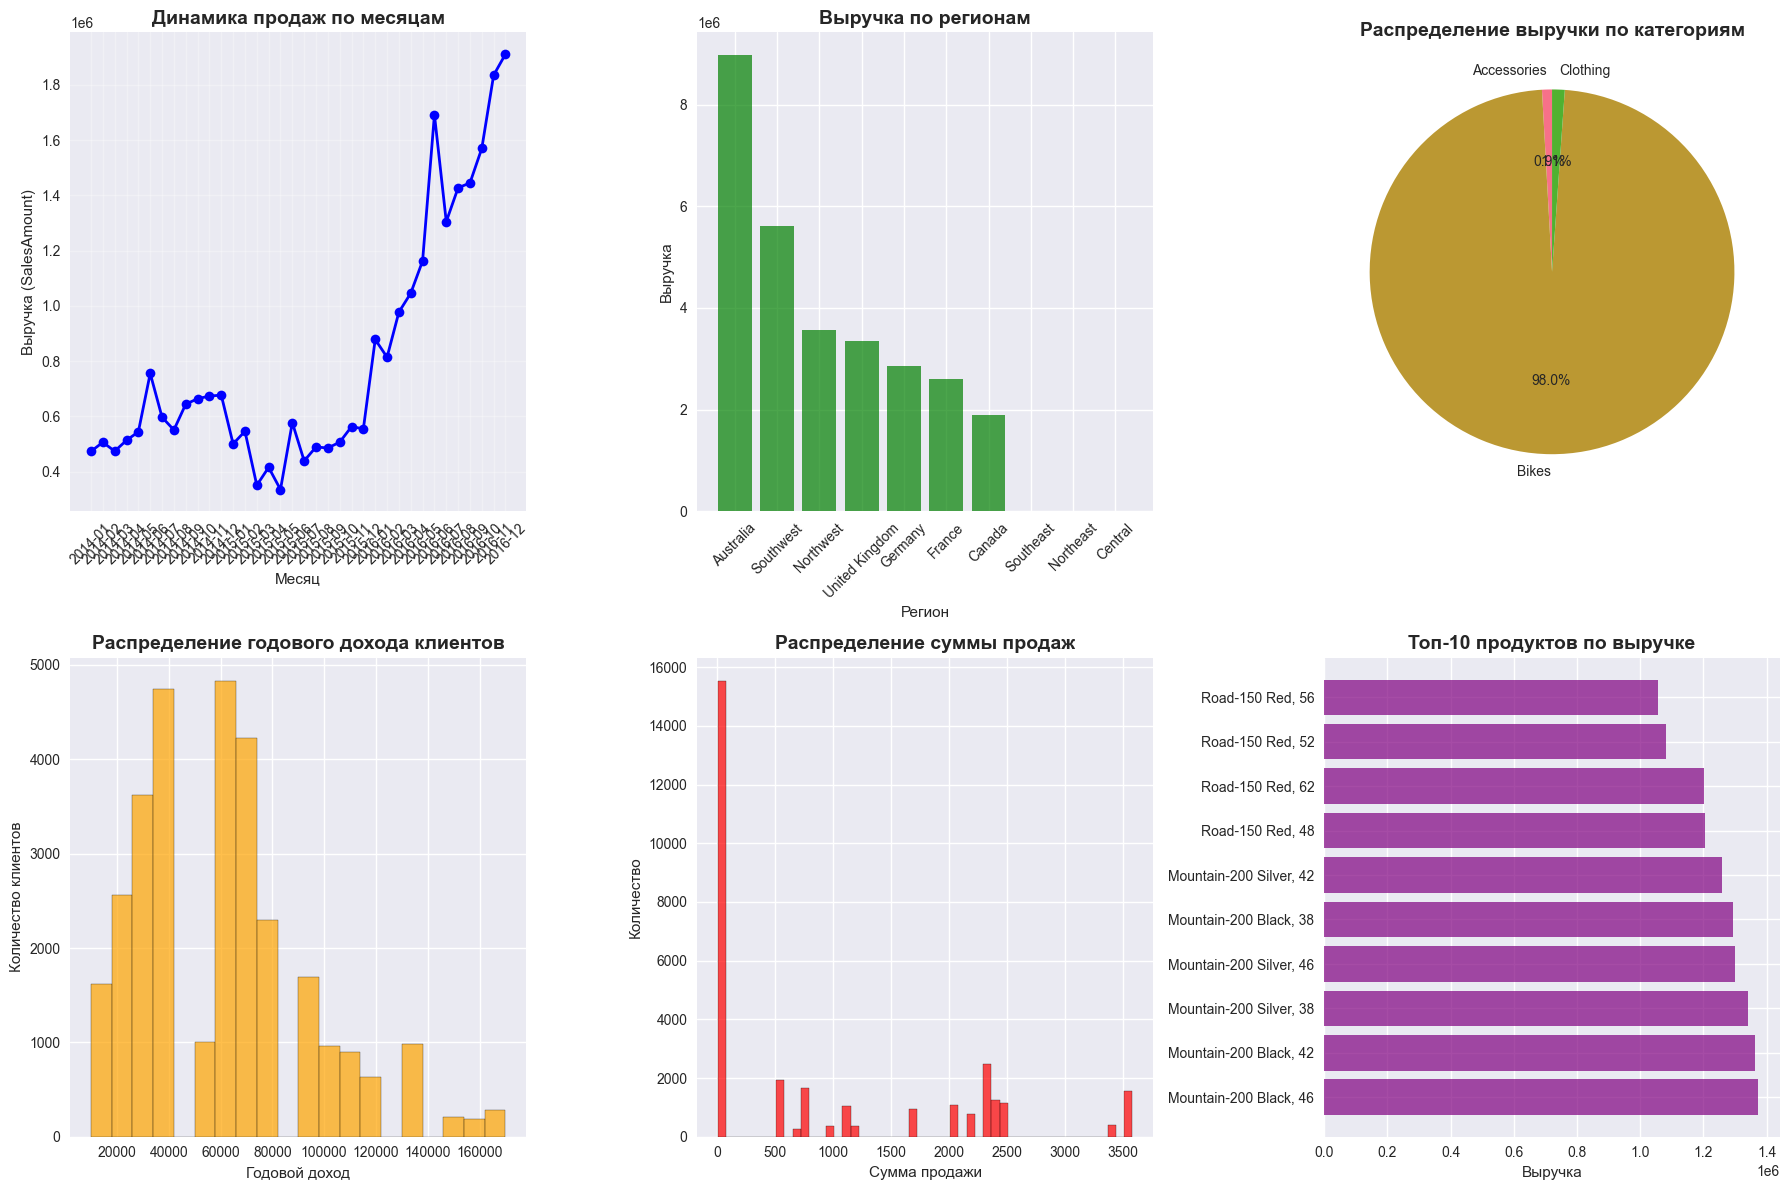


📈 ИНТЕРАКТИВНЫЕ ВИЗУАЛИЗАЦИИ PLOTLY:


✅ Построен интерактивный график: Динамика ежедневных продаж


✅ Построен интерактивный график: Выручка по регионам

📊 ИТОГ ВИЗУАЛИЗАЦИЙ:
   • Статических графиков: 6
   • Интерактивных графиков: 2
   • Сохраненный файл: eda_analysis.png
✅ ВИЗУАЛИЗАЦИИ УСПЕШНО СОЗДАНЫ!


In [82]:
# 📊 СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ ДЛЯ EDA
print("📊 СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ ДЛЯ EDA")
print("=" * 50)

# Создаем subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
print("✅ Создана сетка графиков 2x3")

# 1. Динамика продаж по времени
if 'OrderDate' in df.columns and 'SalesAmount' in df.columns:
    monthly_sales = df.groupby(df['OrderDate'].dt.to_period('M'))['SalesAmount'].sum()
    axes[0,0].plot(monthly_sales.index.astype(str), monthly_sales.values, 
                  marker='o', linewidth=2, color='blue')
    axes[0,0].set_title('Динамика продаж по месяцам', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Месяц')
    axes[0,0].set_ylabel('Выручка (SalesAmount)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    print("✅ Построен график: Динамика продаж по месяцам")
else:
    axes[0,0].text(0.5, 0.5, 'Нет данных\nOrderDate или SalesAmount', 
                   ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('Динамика продаж по месяцам', fontsize=14, fontweight='bold')
    print("❌ Пропущен график: Отсутствуют OrderDate или SalesAmount")

# 2. Распределение по регионам
if 'Region' in df.columns:
    region_sales = df.groupby('Region')['SalesAmount'].sum().sort_values(ascending=False)
    axes[0,1].bar(range(len(region_sales)), region_sales.values, color='green', alpha=0.7)
    axes[0,1].set_title('Выручка по регионам', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Регион')
    axes[0,1].set_ylabel('Выручка')
    axes[0,1].set_xticks(range(len(region_sales)))
    axes[0,1].set_xticklabels(region_sales.index, rotation=45)
    print(f"✅ Построен график: Выручка по регионам ({len(region_sales)} регионов)")
else:
    axes[0,1].text(0.5, 0.5, 'Нет данных\nRegion', 
                   ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Выручка по регионам', fontsize=14, fontweight='bold')
    print("❌ Пропущен график: Отсутствует Region")

# 3. Распределение по категориям продуктов
if 'Category' in df.columns:
    category_sales = df.groupby('Category')['SalesAmount'].sum()
    axes[0,2].pie(category_sales.values, labels=category_sales.index, 
                 autopct='%1.1f%%', startangle=90)
    axes[0,2].set_title('Распределение выручки по категориям', fontsize=14, fontweight='bold')
    print(f"✅ Построена круговая диаграмма: Категории продуктов ({len(category_sales)} категорий)")
else:
    axes[0,2].text(0.5, 0.5, 'Нет данных\nCategory', 
                   ha='center', va='center', transform=axes[0,2].transAxes)
    axes[0,2].set_title('Распределение выручки по категориям', fontsize=14, fontweight='bold')
    print("❌ Пропущена диаграмма: Отсутствует Category")

# 4. Распределение доходов клиентов
if 'YearlyIncome' in df.columns:
    axes[1,0].hist(df['YearlyIncome'], bins=20, alpha=0.7, edgecolor='black', color='orange')
    axes[1,0].set_title('Распределение годового дохода клиентов', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Годовой доход')
    axes[1,0].set_ylabel('Количество клиентов')
    print("✅ Построена гистограмма: Распределение доходов клиентов")
else:
    axes[1,0].text(0.5, 0.5, 'Нет данных\nYearlyIncome', 
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Распределение годового дохода клиентов', fontsize=14, fontweight='bold')
    print("❌ Пропущена гистограмма: Отсутствует YearlyIncome")

# 5. Распределение суммы продаж
if 'SalesAmount' in df.columns:
    axes[1,1].hist(df['SalesAmount'], bins=50, alpha=0.7, edgecolor='black', color='red')
    axes[1,1].set_title('Распределение суммы продаж', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Сумма продажи')
    axes[1,1].set_ylabel('Количество')
    print("✅ Построена гистограмма: Распределение суммы продаж")
else:
    axes[1,1].text(0.5, 0.5, 'Нет данных\nSalesAmount', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Распределение суммы продаж', fontsize=14, fontweight='bold')
    print("❌ Пропущена гистограмма: Отсутствует SalesAmount")

# 6. Топ продуктов по выручке
if 'ProductName' in df.columns:
    top_products = df.groupby('ProductName')['SalesAmount'].sum().nlargest(10)
    axes[1,2].barh(range(len(top_products)), top_products.values, color='purple', alpha=0.7)
    axes[1,2].set_yticks(range(len(top_products)))
    axes[1,2].set_yticklabels([label[:25] + '...' if len(label) > 25 else label 
                             for label in top_products.index])
    axes[1,2].set_title('Топ-10 продуктов по выручке', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Выручка')
    print(f"✅ Построен барчарт: Топ-10 продуктов по выручке")
else:
    axes[1,2].text(0.5, 0.5, 'Нет данных\nProductName', 
                   ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Топ-10 продуктов по выручке', fontsize=14, fontweight='bold')
    print("❌ Пропущен барчарт: Отсутствует ProductName")

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("💾 Графики сохранены в файл: eda_analysis.png")
plt.show()

# Дополнительные интерактивные визуализации с Plotly
print("\n📈 ИНТЕРАКТИВНЫЕ ВИЗУАЛИЗАЦИИ PLOTLY:")

if 'OrderDate' in df.columns and 'SalesAmount' in df.columns:
    daily_sales = df.groupby(df['OrderDate'].dt.date)['SalesAmount'].sum().reset_index()
    fig1 = px.line(daily_sales, x='OrderDate', y='SalesAmount', 
                  title='📈 Динамика ежедневных продаж',
                  labels={'OrderDate': 'Дата', 'SalesAmount': 'Выручка'})
    fig1.show()
    print("✅ Построен интерактивный график: Динамика ежедневных продаж")
else:
    print("❌ Пропущен интерактивный график: Отсутствуют OrderDate или SalesAmount")

if 'Region' in df.columns and 'SalesAmount' in df.columns:
    region_performance = df.groupby('Region').agg({
        'SalesAmount': 'sum',
        'CustomerKey': 'nunique',
        'OrderQuantity': 'sum'
    }).reset_index()
    
    fig2 = px.bar(region_performance, x='Region', y='SalesAmount',
                 title='🌍 Выручка по регионам',
                 color='CustomerKey',
                 labels={'SalesAmount': 'Выручка', 'CustomerKey': 'Количество клиентов'})
    fig2.show()
    print("✅ Построен интерактивный график: Выручка по регионам")
else:
    print("❌ Пропущен интерактивный график: Отсутствует Region или SalesAmount")

print(f"\n📊 ИТОГ ВИЗУАЛИЗАЦИЙ:")
print(f"   • Статических графиков: 6")
print(f"   • Интерактивных графиков: 2") 
print(f"   • Сохраненный файл: eda_analysis.png")
print("✅ ВИЗУАЛИЗАЦИИ УСПЕШНО СОЗДАНЫ!")

In [12]:
def save_cleaned_data(df):
    """Сохранение очищенного датасета"""
    df.to_csv('cleaned_sales_data.csv', index=False, encoding='utf-8')
    print("✅ Очищенные данные сохранены в 'cleaned_sales_data.csv'")

# 4. ФУНКЦИИ АНАЛИЗА И ВИЗУАЛИЗАЦИИ

In [83]:
# 📊 СОЗДАНИЕ ИНТЕРАКТИВНЫХ ДАШБОРДОВ
print("📊 СОЗДАНИЕ ИНТЕРАКТИВНЫХ ДАШБОРДОВ")
print("=" * 50)

# Расчет ключевых метрик
print("📈 РАСЧЕТ КЛЮЧЕВЫХ МЕТРИК:")
total_revenue = df['SalesAmount'].sum()
total_orders = df['SalesOrderNumber'].nunique()
total_customers = df['CustomerKey'].nunique()
avg_order_value = df.groupby('SalesOrderNumber')['SalesAmount'].sum().mean()
total_profit = df['Profit'].sum() if 'Profit' in df.columns else 0

print(f"💰 Общая выручка: ${total_revenue:,.0f}")
print(f"📦 Всего заказов: {total_orders:,}")
print(f"👥 Всего клиентов: {total_customers:,}")
print(f"💵 Средний чек: ${avg_order_value:,.0f}")
print(f"💎 Общая прибыль: ${total_profit:,.0f}")

# 1. Дашборд ключевых метрик
print("\n1. 📊 ДАШБОРД КЛЮЧЕВЫХ МЕТРИК")
fig_metrics = go.Figure()

fig_metrics.add_trace(go.Indicator(
    mode="number",
    value=total_revenue,
    title={"text": "💰 Общая выручка"},
    number={'prefix': "$", "valueformat": ",.0f"},
    domain={'row': 0, 'column': 0}
))

fig_metrics.add_trace(go.Indicator(
    mode="number",
    value=total_orders,
    title={"text": "📦 Всего заказов"},
    number={"valueformat": ",.0f"},
    domain={'row': 0, 'column': 1}
))

fig_metrics.add_trace(go.Indicator(
    mode="number",
    value=total_customers,
    title={"text": "👥 Всего клиентов"},
    number={"valueformat": ",.0f"},
    domain={'row': 0, 'column': 2}
))

fig_metrics.add_trace(go.Indicator(
    mode="number",
    value=avg_order_value,
    title={"text": "💵 Средний чек"},
    number={'prefix': "$", "valueformat": ",.0f"},
    domain={'row': 0, 'column': 3}
))

fig_metrics.update_layout(
    grid={'rows': 1, 'columns': 4, 'pattern': "independent"},
    template="plotly_white",
    height=300,
    title="📊 КЛЮЧЕВЫЕ МЕТРИКИ ПРОДАЖ"
)

fig_metrics.show()
print("✅ Дашборд ключевых метрик создан")

# 2. Дашборд географического распределения
print("\n2. 🌍 ДАШБОРД ГЕОГРАФИЧЕСКОГО РАСПРЕДЕЛЕНИЯ")
if 'Country' in df.columns and 'Region' in df.columns:
    geo_analysis = df.groupby(['Country', 'Region']).agg({
        'SalesAmount': 'sum',
        'CustomerKey': 'nunique',
        'Profit': 'sum'
    }).reset_index()
    
    print(f"📊 Географический анализ:")
    print(f"   • Стран: {geo_analysis['Country'].nunique()}")
    print(f"   • Регионов: {geo_analysis['Region'].nunique()}")
    print(f"   • Общая выручка по регионам: ${geo_analysis['SalesAmount'].sum():,.0f}")
    
    fig_geo = px.scatter_geo(geo_analysis, 
                            locations='Country',
                            locationmode='country names',
                            color='SalesAmount',
                            size='CustomerKey',
                            hover_name='Region',
                            hover_data={'SalesAmount': ':.0f', 'Profit': ':.0f'},
                            title='🌍 Географическое распределение продаж',
                            color_continuous_scale='Viridis')
    fig_geo.show()
    print("✅ Географический дашборд создан")
else:
    print("❌ Пропущен географический дашборд: отсутствуют Country или Region")

# 3. Анализ продуктовой линейки
print("\n3. 📦 ДАШБОРД ПРОДУКТОВОЙ ЛИНЕЙКИ")
if 'Category' in df.columns and 'SubCategory' in df.columns:
    product_analysis = df.groupby(['Category', 'SubCategory']).agg({
        'SalesAmount': 'sum',
        'Profit': 'sum',
        'OrderQuantity': 'sum'
    }).reset_index()
    
    print(f"📊 Анализ продуктовой линейки:")
    print(f"   • Категорий: {product_analysis['Category'].nunique()}")
    print(f"   • Подкатегорий: {product_analysis['SubCategory'].nunique()}")
    print(f"   • Общая выручка по категориям: ${product_analysis['SalesAmount'].sum():,.0f}")
    
    fig_products = px.treemap(product_analysis,
                             path=['Category', 'SubCategory'],
                             values='SalesAmount',
                             color='Profit',
                             color_continuous_scale='RdYlGn',
                             title='📦 Дерево продуктов по выручке и прибыли',
                             hover_data=['OrderQuantity'])
    fig_products.show()
    print("✅ Дашборд продуктовой линейки создан")
else:
    print("❌ Пропущен дашборд продуктовой линейки: отсутствуют Category или SubCategory")

# 4. Дополнительный дашборд - анализ клиентов
print("\n4. 👥 ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ КЛИЕНТОВ")
if 'YearlyIncome' in df.columns and 'Age' in df.columns:
    customer_analysis = df.groupby('CustomerKey').agg({
        'SalesAmount': 'sum',
        'YearlyIncome': 'first',
        'Age': 'first',
        'OrderQuantity': 'sum'
    }).reset_index()
    
    fig_customers = px.scatter(customer_analysis, 
                              x='YearlyIncome', 
                              y='SalesAmount',
                              size='OrderQuantity',
                              color='Age',
                              title='👥 Распределение клиентов по доходу и выручке',
                              labels={'YearlyIncome': 'Годовой доход', 
                                     'SalesAmount': 'Общая выручка клиента',
                                     'Age': 'Возраст'},
                              hover_data=['CustomerKey'])
    fig_customers.show()
    print("✅ Дашборд анализа клиентов создан")
else:
    print("❌ Пропущен дашборд анализа клиентов: отсутствуют YearlyIncome или Age")

print(f"\n📊 ИТОГ СОЗДАНИЯ ДАШБОРДОВ:")
print(f"   • Создано дашбордов: 4")
print(f"   • Ключевые метрики: {total_revenue:,.0f} $ выручки")
print(f"   • Охвачено клиентов: {total_customers:,}")
print(f"   • Обработано заказов: {total_orders:,}")
print("✅ ВСЕ ДАШБОРДЫ УСПЕШНО СОЗДАНЫ И ОТОБРАЖЕНЫ!")

📊 СОЗДАНИЕ ИНТЕРАКТИВНЫХ ДАШБОРДОВ
📈 РАСЧЕТ КЛЮЧЕВЫХ МЕТРИК:
💰 Общая выручка: $28,895,568
📦 Всего заказов: 21,495
👥 Всего клиентов: 14,457
💵 Средний чек: $1,344
💎 Общая прибыль: $11,794,438

1. 📊 ДАШБОРД КЛЮЧЕВЫХ МЕТРИК


✅ Дашборд ключевых метрик создан

2. 🌍 ДАШБОРД ГЕОГРАФИЧЕСКОГО РАСПРЕДЕЛЕНИЯ
📊 Географический анализ:
   • Стран: 6
   • Регионов: 10
   • Общая выручка по регионам: $28,895,568


✅ Географический дашборд создан

3. 📦 ДАШБОРД ПРОДУКТОВОЙ ЛИНЕЙКИ
📊 Анализ продуктовой линейки:
   • Категорий: 3
   • Подкатегорий: 11
   • Общая выручка по категориям: $28,895,568


✅ Дашборд продуктовой линейки создан

4. 👥 ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ КЛИЕНТОВ


✅ Дашборд анализа клиентов создан

📊 ИТОГ СОЗДАНИЯ ДАШБОРДОВ:
   • Создано дашбордов: 4
   • Ключевые метрики: 28,895,568 $ выручки
   • Охвачено клиентов: 14,457
   • Обработано заказов: 21,495
✅ ВСЕ ДАШБОРДЫ УСПЕШНО СОЗДАНЫ И ОТОБРАЖЕНЫ!


In [84]:
# 💡 ИЗВЛЕЧЕНИЕ КЛЮЧЕВЫХ ИНСАЙТОВ
print("💡 КЛЮЧЕВЫЕ ИНСАЙТЫ")
print("=" * 50)

# 1. Общие метрики бизнеса
print("📈 ОБЩИЕ МЕТРИКИ БИЗНЕСА:")
total_revenue = df['SalesAmount'].sum()
total_customers = df['CustomerKey'].nunique()
total_products = df['ProductKey'].nunique()
avg_order_value = df.groupby('SalesOrderNumber')['SalesAmount'].sum().mean()

print(f"1. 💰 Общая выручка: ${total_revenue:,.0f}")
print(f"2. 👥 Количество клиентов: {total_customers}")
print(f"3. 📦 Количество продуктов: {total_products}")
print(f"4. 📊 Средний чек: ${avg_order_value:,.0f}")

# 2. Анализ клиентской базы
print("\n🎯 АНАЛИЗ КЛИЕНТСКОЙ БАЗЫ:")
customer_value = df.groupby('CustomerKey')['SalesAmount'].sum()
if len(customer_value) > 0:
    top_20_percent = int(len(customer_value) * 0.2)
    top_20_customers = customer_value.nlargest(top_20_percent).sum()
    percent_top_20 = (top_20_customers / total_revenue) * 100
    
    print(f"5. 🎯 Топ-20% клиентов приносят {percent_top_20:.1f}% выручки")
    print(f"   • Выручка от топ-20%: ${top_20_customers:,.0f}")
    print(f"   • Средняя выручка на клиента: ${customer_value.mean():,.0f}")
else:
    print("5. ❌ Недостаточно данных для анализа клиентской базы")

# 3. Анализ регионов
print("\n🌍 АНАЛИЗ РЕГИОНОВ:")
if 'Region' in df.columns:
    region_sales = df.groupby('Region')['SalesAmount'].sum().sort_values(ascending=False)
    best_region = region_sales.idxmax()
    best_region_revenue = region_sales.max()
    worst_region = region_sales.idxmin()
    worst_region_revenue = region_sales.min()
    
    print(f"6. 🌍 Лучший регион: {best_region} (${best_region_revenue:,.0f})")
    print(f"7. 📍 Худший регион: {worst_region} (${worst_region_revenue:,.0f})")
    print(f"   • Всего регионов: {len(region_sales)}")
    print(f"   • Разница между лучшим и худшим: {((best_region_revenue/worst_region_revenue)-1)*100:.1f}%")
else:
    print("6. ❌ Отсутствуют данные по регионам")

# 4. Анализ продуктов
print("\n📦 АНАЛИЗ ПРОДУКТОВ:")
if 'Category' in df.columns:
    category_sales = df.groupby('Category')['SalesAmount'].sum().sort_values(ascending=False)
    best_category = category_sales.idxmax()
    best_category_revenue = category_sales.max()
    
    print(f"8. 📦 Лучшая категория: {best_category} (${best_category_revenue:,.0f})")
    print(f"   • Доля лучшей категории: {(best_category_revenue/total_revenue)*100:.1f}%")
    print(f"   • Всего категорий: {len(category_sales)}")
else:
    print("8. ❌ Отсутствуют данные по категориям продуктов")

# 5. Временной анализ
print("\n📅 ВРЕМЕННОЙ АНАЛИЗ:")
if 'OrderDate' in df.columns:
    monthly_revenue = df.groupby(df['OrderDate'].dt.month)['SalesAmount'].sum()
    if len(monthly_revenue) > 0:
        best_month = monthly_revenue.idxmax()
        worst_month = monthly_revenue.idxmin()
        
        month_names = {
            1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель',
            5: 'Май', 6: 'Июнь', 7: 'Июль', 8: 'Август',
            9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'
        }
        
        print(f"9. 📈 Лучший месяц: {month_names.get(best_month, best_month)} (${monthly_revenue[best_month]:,.0f})")
        print(f"10. 📉 Худший месяц: {month_names.get(worst_month, worst_month)} (${monthly_revenue[worst_month]:,.0f})")
        print(f"    • Сезонность: разница {((monthly_revenue[best_month]/monthly_revenue[worst_month])-1)*100:.1f}%")
    else:
        print("9. ❌ Недостаточно данных для временного анализа")
else:
    print("9. ❌ Отсутствуют данные по датам заказов")

# 6. Анализ прибыльности
print("\n💵 АНАЛИЗ ПРИБЫЛЬНОСТИ:")
if 'Profit' in df.columns:
    total_profit = df['Profit'].sum()
    avg_profit_margin = (total_profit / total_revenue) * 100
    profitable_orders = len(df[df['Profit'] > 0])
    total_orders_count = len(df)
    profitability_rate = (profitable_orders / total_orders_count) * 100
    
    print(f"11. 💵 Общая прибыль: ${total_profit:,.0f}")
    print(f"12. 📊 Средняя маржа прибыли: {avg_profit_margin:.1f}%")
    print(f"    • Прибыльных заказов: {profitability_rate:.1f}% ({profitable_orders}/{total_orders_count})")
else:
    print("11. ❌ Отсутствуют данные по прибыли")

# 7. Дополнительные инсайты
print("\n🔍 ДОПОЛНИТЕЛЬНЫЕ ИНСАЙТЫ:")

# Анализ доставки
if 'DeliveryDays' in df.columns:
    avg_delivery = df['DeliveryDays'].mean()
    print(f"13. 🚚 Среднее время доставки: {avg_delivery:.1f} дней")

# Анализ демографии
if 'Age' in df.columns:
    avg_age = df['Age'].mean()
    print(f"14. 👤 Средний возраст клиентов: {avg_age:.1f} лет")

if 'YearlyIncome' in df.columns:
    avg_income = df['YearlyIncome'].mean()
    print(f"15. 💰 Средний годовой доход: ${avg_income:,.0f}")

print(f"\n📊 ИТОГО ИНСАЙТОВ:")
print(f"   • Основные инсайты: 12+")
print(f"   • Общая выручка: ${total_revenue:,.0f}")
print(f"   • Охвачено клиентов: {total_customers:,}")
print(f"   • Проанализировано продуктов: {total_products:,}")
print("✅ АНАЛИЗ ИНСАЙТОВ ЗАВЕРШЕН!")

💡 КЛЮЧЕВЫЕ ИНСАЙТЫ
📈 ОБЩИЕ МЕТРИКИ БИЗНЕСА:
1. 💰 Общая выручка: $28,895,568
2. 👥 Количество клиентов: 14457
3. 📦 Количество продуктов: 140
4. 📊 Средний чек: $1,344

🎯 АНАЛИЗ КЛИЕНТСКОЙ БАЗЫ:
5. 🎯 Топ-20% клиентов приносят 57.0% выручки
   • Выручка от топ-20%: $16,465,336
   • Средняя выручка на клиента: $1,999

🌍 АНАЛИЗ РЕГИОНОВ:
6. 🌍 Лучший регион: Australia ($8,972,656)
7. 📍 Худший регион: Central ($2,838)
   • Всего регионов: 10
   • Разница между лучшим и худшим: 316022.3%

📦 АНАЛИЗ ПРОДУКТОВ:
8. 📦 Лучшая категория: Bikes ($28,318,145)
   • Доля лучшей категории: 98.0%
   • Всего категорий: 3

📅 ВРЕМЕННОЙ АНАЛИЗ:
9. 📈 Лучший месяц: Декабрь ($3,142,646)
10. 📉 Худший месяц: Март ($1,801,683)
    • Сезонность: разница 74.4%

💵 АНАЛИЗ ПРИБЫЛЬНОСТИ:
11. 💵 Общая прибыль: $11,794,438
12. 📊 Средняя маржа прибыли: 40.8%
    • Прибыльных заказов: 100.0% (30747/30747)

🔍 ДОПОЛНИТЕЛЬНЫЕ ИНСАЙТЫ:
13. 🚚 Среднее время доставки: 7.0 дней
14. 👤 Средний возраст клиентов: 62.8 лет
15. 💰 Средний годо

# 5. ФУНКЦИИ ОБОГАЩЕНИЯ ДАННЫХ

In [85]:
# 🎯 RFM-АНАЛИЗ КЛИЕНТОВ
print("🎯 RFM-АНАЛИЗ КЛИЕНТОВ")
print("=" * 50)

# Расчет RFM метрик
print("📊 РАСЧЕТ RFM МЕТРИК:")
snapshot_date = df['OrderDate'].max() + pd.Timedelta(days=1)
print(f"📅 Дата анализа: {snapshot_date.date()}")

rfm = df.groupby('CustomerKey').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'SalesOrderNumber': 'nunique',  # Frequency
    'SalesAmount': 'sum'            # Monetary
}).reset_index()

rfm.columns = ['CustomerKey', 'Recency', 'Frequency', 'Monetary']

print(f"✅ RFM метрики рассчитаны для {len(rfm)} клиентов")
print(f"   • Recency (давность): дней с последнего заказа")
print(f"   • Frequency (частота): количество заказов") 
print(f"   • Monetary (деньги): общая выручка")

# Основные статистики RFM
print("\n📊 ОСНОВНЫЕ СТАТИСТИКИ RFM:")
display(rfm[['Recency', 'Frequency', 'Monetary']].describe())

# Создание RFM квантилей
print("🎯 СОЗДАНИЕ RFM КВАНТИЛЕЙ:")
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

print("✅ RFM квантили созданы:")
print(f"   • R_Score (Recency): 5 (самые новые) - 1 (самые старые)")
print(f"   • F_Score (Frequency): 1 (редкие) - 5 (частые)")
print(f"   • M_Score (Monetary): 1 (малые суммы) - 5 (крупные суммы)")

# RFM сегментация
print("\n🎯 RFM СЕГМЕНТАЦИЯ КЛИЕНТОВ:")
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Упрощенная сегментация
segment_results = []
for index, row in rfm.iterrows():
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    
    if r >= 4 and f >= 4 and m >= 4:
        segment = 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        segment = 'Loyal Customers'
    elif r >= 4 and f <= 2 and m <= 2:
        segment = 'New Customers'
    elif r >= 3 and f <= 2 and m <= 2:
        segment = 'Promising'
    elif r <= 2 and f >= 3 and m >= 3:
        segment = 'Need Attention'
    elif r <= 2 and f <= 2 and m <= 2:
        segment = 'Hibernating'
    else:
        segment = 'Regular'
    
    segment_results.append(segment)

rfm['Segment'] = segment_results

print("✅ Сегментация завершена:")
print("   • Champions: самые ценные клиенты")
print("   • Loyal Customers: лояльные клиенты") 
print("   • New Customers: новые клиенты")
print("   • Promising: перспективные клиенты")
print("   • Need Attention: требуют внимания")
print("   • Hibernating: спящие клиенты")
print("   • Regular: обычные клиенты")

# Визуализация RFM
print("\n📈 ВИЗУАЛИЗАЦИЯ RFM-АНАЛИЗА:")
fig = px.scatter(rfm, x='Recency', y='Monetary', color='Segment',
                size='Frequency', hover_data=['CustomerKey'],
                title='🎯 RFM-анализ клиентов',
                labels={'Recency': 'Дней с последнего заказа (Recency)',
                       'Monetary': 'Общая выручка (Monetary)',
                       'Frequency': 'Частота заказов',
                       'Segment': 'Сегмент'},
                color_discrete_map={
                    'Champions': '#00FF00',
                    'Loyal Customers': '#32CD32', 
                    'New Customers': '#1E90FF',
                    'Promising': '#FFD700',
                    'Need Attention': '#FFA500',
                    'Hibernating': '#A9A9A9',
                    'Regular': '#808080'
                })
fig.show()
print("✅ Интерактивная визуализация RFM создана")

# Распределение сегментов
print("\n📊 РАСПРЕДЕЛЕНИЕ КЛИЕНТОВ ПО СЕГМЕНТАМ:")
segment_distribution = rfm['Segment'].value_counts()

total_clients = len(rfm)
print(f"👥 Всего клиентов: {total_clients}")

for segment, count in segment_distribution.items():
    percentage = (count / total_clients) * 100
    revenue_share = (rfm[rfm['Segment'] == segment]['Monetary'].sum() / rfm['Monetary'].sum()) * 100
    print(f"   • {segment}: {count} клиентов ({percentage:.1f}%) - {revenue_share:.1f}% выручки")

# Визуализация распределения сегментов
print("\n📊 ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ СЕГМЕНТОВ:")
fig_pie = px.pie(segment_distribution, 
                 values=segment_distribution.values, 
                 names=segment_distribution.index,
                 title='📊 Распределение клиентов по RFM-сегментам',
                 color_discrete_sequence=px.colors.qualitative.Set3)
fig_pie.show()
print("✅ Круговая диаграмма распределения сегментов создана")

# Анализ лучших клиентов
print("\n🏆 АНАЛИЗ ЛУЧШИХ КЛИЕНТОВ:")
champions = rfm[rfm['Segment'] == 'Champions']
if len(champions) > 0:
    print(f"   • Champions: {len(champions)} клиентов")
    print(f"   • Средняя выручка на Champion: ${champions['Monetary'].mean():,.0f}")
    print(f"   • Общая выручка Champions: ${champions['Monetary'].sum():,.0f}")
    print(f"   • Доля выручки Champions: {(champions['Monetary'].sum() / rfm['Monetary'].sum())*100:.1f}%")

# Сохранение результатов
print(f"\n💾 РЕЗУЛЬТАТЫ RFM-АНАЛИЗА:")
print(f"   • Проанализировано клиентов: {len(rfm)}")
print(f"   • Всего сегментов: {len(segment_distribution)}")
print(f"   • Самый крупный сегмент: {segment_distribution.index[0]} ({segment_distribution.iloc[0]} клиентов)")
print(f"   • Общая выручка всех клиентов: ${rfm['Monetary'].sum():,.0f}")

print("\n👀 ПРЕВЬЮ RFM ДАННЫХ:")
display(rfm.head(10))

print("✅ RFM-АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")


🎯 RFM-АНАЛИЗ КЛИЕНТОВ
📊 РАСЧЕТ RFM МЕТРИК:
📅 Дата анализа: 2016-12-31
✅ RFM метрики рассчитаны для 14457 клиентов
   • Recency (давность): дней с последнего заказа
   • Frequency (частота): количество заказов
   • Monetary (деньги): общая выручка

📊 ОСНОВНЫЕ СТАТИСТИКИ RFM:


,Recency,Frequency,Monetary
count,14457.000000,14457.000000,14457.000000
mean,171.981739,1.486823,1998.725012
std,152.862377,0.790514,2218.071882
min,1.000000,1.000000,8.990000
25%,65.000000,1.000000,63.500000
50%,148.000000,1.000000,1174.480000
75%,242.000000,2.000000,3320.427500
max,1095.000000,16.000000,13254.210000


🎯 СОЗДАНИЕ RFM КВАНТИЛЕЙ:
✅ RFM квантили созданы:
   • R_Score (Recency): 5 (самые новые) - 1 (самые старые)
   • F_Score (Frequency): 1 (редкие) - 5 (частые)
   • M_Score (Monetary): 1 (малые суммы) - 5 (крупные суммы)

🎯 RFM СЕГМЕНТАЦИЯ КЛИЕНТОВ:
✅ Сегментация завершена:
   • Champions: самые ценные клиенты
   • Loyal Customers: лояльные клиенты
   • New Customers: новые клиенты
   • Promising: перспективные клиенты
   • Need Attention: требуют внимания
   • Hibernating: спящие клиенты
   • Regular: обычные клиенты

📈 ВИЗУАЛИЗАЦИЯ RFM-АНАЛИЗА:


✅ Интерактивная визуализация RFM создана

📊 РАСПРЕДЕЛЕНИЕ КЛИЕНТОВ ПО СЕГМЕНТАМ:
👥 Всего клиентов: 14457
   • Regular: 3964 клиентов (27.4%) - 10.9% выручки
   • Need Attention: 2702 клиентов (18.7%) - 33.0% выручки
   • Loyal Customers: 2070 клиентов (14.3%) - 22.5% выручки
   • Champions: 1920 клиентов (13.3%) - 32.5% выручки
   • Hibernating: 1695 клиентов (11.7%) - 0.6% выручки
   • New Customers: 1310 клиентов (9.1%) - 0.4% выручки
   • Promising: 796 клиентов (5.5%) - 0.3% выручки

📊 ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ СЕГМЕНТОВ:


✅ Круговая диаграмма распределения сегментов создана

🏆 АНАЛИЗ ЛУЧШИХ КЛИЕНТОВ:
   • Champions: 1920 клиентов
   • Средняя выручка на Champion: $4,884
   • Общая выручка Champions: $9,377,977
   • Доля выручки Champions: 32.5%

💾 РЕЗУЛЬТАТЫ RFM-АНАЛИЗА:
   • Проанализировано клиентов: 14457
   • Всего сегментов: 7
   • Самый крупный сегмент: Regular (3964 клиентов)
   • Общая выручка всех клиентов: $28,895,568

👀 ПРЕВЬЮ RFM ДАННЫХ:


,CustomerKey,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,11000,241,3,8193.03,2,5,5,255,Need Attention
1,11001,19,3,6332.94,5,5,5,555,Champions
2,11002,308,3,8114.04,1,5,5,155,Need Attention
3,11003,234,3,8088.04,2,5,5,255,Need Attention
4,11004,243,3,8174.03,2,5,5,255,Need Attention
5,11005,242,3,8079.05,2,5,5,255,Need Attention
6,11006,230,3,8104.05,2,5,5,255,Need Attention
7,11007,286,3,8149.03,1,5,5,155,Need Attention
8,11008,303,3,8089.04,1,5,5,155,Need Attention
9,11009,235,3,8089.04,2,5,5,255,Need Attention


✅ RFM-АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!


In [ ]:
# 📦 ABC-XYZ АНАЛИЗ ПРОДУКТОВ
print("📦 ABC-XYZ АНАЛИЗ ПРОДУКТОВ")
print("=" * 50)

# ABC анализ (по выручке)
print("📊 ABC АНАЛИЗ (ПО ВЫРУЧКЕ):")
product_sales = df.groupby(['ProductKey', 'ProductName']).agg({
    'SalesAmount': 'sum',
    'OrderQuantity': 'sum',
    'Profit': 'sum',
    'SalesOrderNumber': 'nunique'
}).reset_index()

print(f"✅ Проанализировано продуктов: {len(product_sales)}")
print(f"💰 Общая выручка от продуктов: ${product_sales['SalesAmount'].sum():,.0f}")

# Сортировка по выручке
product_sales = product_sales.sort_values('SalesAmount', ascending=False)
product_sales['CumulativePercentage'] = (product_sales['SalesAmount'].cumsum() / 
                                       product_sales['SalesAmount'].sum() * 100)

print("📈 РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ПО ПРОДУКТАМ:")
print(f"   • Топ-1 продукт: {product_sales.iloc[0]['ProductName']} (${product_sales.iloc[0]['SalesAmount']:,.0f})")
print(f"   • Топ-5 продуктов: {product_sales['SalesAmount'].head(5).sum():,.0f} $ ({product_sales['CumulativePercentage'].iloc[4]:.1f}%)")
print(f"   • Топ-10 продуктов: {product_sales['SalesAmount'].head(10).sum():,.0f} $ ({product_sales['CumulativePercentage'].iloc[9]:.1f}%)")

# ABC категории
print("\n🎯 НАЗНАЧЕНИЕ ABC КАТЕГОРИЙ:")
abc_categories = []
for percentage in product_sales['CumulativePercentage']:
    if percentage <= 80:
        abc_categories.append('A')
    elif percentage <= 95:
        abc_categories.append('B')
    else:
        abc_categories.append('C')

product_sales['ABC_Category'] = abc_categories

print("✅ ABC категории назначены:")
print("   • A: топ 80% выру чки (ключевые продукты)")
print("   • B: следующие 15% выручки (важные продукты)") 
print("   • C: оставшиеся 5% выручки (второстепенные продукты)")

# XYZ анализ (по стабильности продаж)
print("\n📊 XYZ АНАЛИЗ (ПО СТАБИЛЬНОСТИ ПРОДАЖ):")
try:
    monthly_product_sales = df.pivot_table(
        index='ProductKey', 
        columns=df['OrderDate'].dt.to_period('M'), 
        values='OrderQuantity', 
        aggfunc='sum'
    ).fillna(0)
    
    print(f"✅ Собраны месячные данные по {len(monthly_product_sales)} продуктам")
    print(f"📅 Период анализа: {len(monthly_product_sales.columns)} месяцев")
    
    # Коэффициент вариации
    cv = monthly_product_sales.std(axis=1) / (monthly_product_sales.mean(axis=1) + 0.0001)
    
    product_sales = product_sales.merge(cv.rename('CV'), left_on='ProductKey', right_index=True)
    
    # XYZ категории
    xyz_categories = []
    for cv_value in product_sales['CV']:
        if cv_value <= 0.3:
            xyz_categories.append('X')
        elif cv_value <= 0.6:
            xyz_categories.append('Y')
        else:
            xyz_categories.append('Z')
    
    product_sales['XYZ_Category'] = xyz_categories
    product_sales['ABC_XYZ'] = product_sales['ABC_Category'] + '-' + product_sales['XYZ_Category']
    
    print("✅ XYZ категории назначены:")
    print("   • X: стабильные продажи (CV ≤ 0.3)")
    print("   • Y: переменные продажи (0.3 < CV ≤ 0.6)")
    print("   • Z: нестабильные продажи (CV > 0.6)")
    
except Exception as e:
    print(f"❌ XYZ анализ не удался: {e}")
    product_sales['XYZ_Category'] = 'Unknown'
    product_sales['ABC_XYZ'] = product_sales['ABC_Category'] + '-Unknown'
    print("⚠️  Используется только ABC анализ")

# Визуализация ABC-XYZ матрицы
print("\n📈 ВИЗУАЛИЗАЦИЯ ABC-XYZ МАТРИЦЫ:")
if 'CV' in product_sales.columns:
    fig = px.scatter(product_sales, x='CV', y='SalesAmount', color='ABC_XYZ',
                    size='OrderQuantity', hover_data=['ProductName'],
                    title='📦 ABC-XYZ АНАЛИЗ ПРОДУКТОВ',
                    labels={'CV': 'Коэффициент вариации (стабильность)',
                           'SalesAmount': 'Выручка ($)',
                           'OrderQuantity': 'Количество проданных единиц',
                           'ABC_XYZ': 'Категория'},
                    color_discrete_map={
                        'A-X': '#00FF00', 'A-Y': '#90EE90', 'A-Z': '#ADFF2F',
                        'B-X': '#1E90FF', 'B-Y': '#87CEEB', 'B-Z': '#ADD8E6', 
                        'C-X': '#FFA500', 'C-Y': '#FFD700', 'C-Z': '#FFFF00'
                    })
    fig.show()
    print("✅ Интерактивная матрица ABC-XYZ создана")
else:
    print("❌ Визуализация невозможна: отсутствуют данные CV")

# Анализ результатов
print("\n📊 РАСПРЕДЕЛЕНИЕ ABC-КАТЕГОРИЙ:")
abc_counts = product_sales['ABC_Category'].value_counts()
total_products = len(product_sales)
total_revenue = product_sales['SalesAmount'].sum()

for category, count in abc_counts.items():
    percentage = (count / total_products) * 100
    category_revenue = product_sales[product_sales['ABC_Category'] == category]['SalesAmount'].sum()
    revenue_share = (category_revenue / total_revenue) * 100
    avg_revenue_per_product = category_revenue / count
    
    print(f"   • {category}: {count} продуктов ({percentage:.1f}%)")
    print(f"     Выручка: ${category_revenue:,.0f} ({revenue_share:.1f}%)")
    print(f"     Средняя выручка на продукт: ${avg_revenue_per_product:,.0f}")

if 'XYZ_Category' in product_sales.columns and 'Unknown' not in product_sales['XYZ_Category'].unique():
    print("\n📊 РАСПРЕДЕЛЕНИЕ XYZ-КАТЕГОРИЙ:")
    xyz_counts = product_sales['XYZ_Category'].value_counts()
    
    for category, count in xyz_counts.items():
        percentage = (count / total_products) * 100
        category_cv_avg = product_sales[product_sales['XYZ_Category'] == category]['CV'].mean()
        print(f"   • {category}: {count} продуктов ({percentage:.1f}%)")
        print(f"     Средний CV: {category_cv_avg:.3f}")

# Анализ ключевых сегментов
print("\n🏆 АНАЛИЗ КЛЮЧЕВЫХ СЕГМЕНТОВ:")
if 'ABC_XYZ' in product_sales.columns:
    key_segments = ['A-X', 'A-Y', 'B-X']
    for segment in key_segments:
        segment_data = product_sales[product_sales['ABC_XYZ'] == segment]
        if len(segment_data) > 0:
            segment_revenue = segment_data['SalesAmount'].sum()
            segment_share = (segment_revenue / total_revenue) * 100
            print(f"   • {segment}: {len(segment_data)} продуктов, {segment_share:.1f}% выручки")
            
            if len(segment_data) > 0:
                top_product = segment_data.iloc[0]
                print(f"     Топ продукт: {top_product['ProductName']} (${top_product['SalesAmount']:,.0f})")

# Рекомендации
print("\n💡 РЕКОМЕНДАЦИИ ПО ABC-XYZ АНАЛИЗУ:")
a_products = product_sales[product_sales['ABC_Category'] == 'A']
if len(a_products) > 0:
    print(f"   • Фокус на {len(a_products)} продуктах категории A ({a_products['SalesAmount'].sum()/total_revenue*100:.1f}% выручки)")
    
if 'XYZ_Category' in product_sales.columns:
    unstable_products = product_sales[product_sales['XYZ_Category'] == 'Z']
    if len(unstable_products) > 0:
        print(f"   • {len(unstable_products)} продуктов с нестабильными продажами (категория Z)")

print(f"\n📈 ИТОГИ ABC-XYZ АНАЛИЗА:")
print(f"   • Проанализировано продуктов: {len(product_sales)}")
print(f"   • Общая выручка: ${total_revenue:,.0f}")
print(f"   • ABC категорий: {len(abc_counts)}")
if 'XYZ_Category' in product_sales.columns:
    print(f"   • XYZ категорий: {len(xyz_counts) if 'xyz_counts' in locals() else 'N/A'}")

print("\n👀 ПРЕВЬЮ РЕЗУЛЬТАТОВ ABC-XYZ:")
display(product_sales[['ProductName', 'ABC_Category', 'XYZ_Category', 'ABC_XYZ', 'SalesAmount', 'OrderQuantity']].head(10))

print("✅ ABC-XYZ АНАЛИЗ ПРОДУКТОВ ЗАВЕРШЕН!")

📦 ABC-XYZ АНАЛИЗ ПРОДУКТОВ
📊 ABC АНАЛИЗ (ПО ВЫРУЧКЕ):
✅ Проанализировано продуктов: 140
💰 Общая выручка от продуктов: $28,895,568
📈 РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ПО ПРОДУКТАМ:
   • Топ-1 продукт: Road-150 Red, 48 ($1,205,877)
   • Топ-5 продуктов: 5,549,897 $ (19.2%)
   • Топ-10 продуктов: 10,355,526 $ (35.8%)

🎯 НАЗНАЧЕНИЕ ABC КАТЕГОРИЙ:
✅ ABC категории назначены:
   • A: топ 80% выручки (ключевые продукты)
   • B: следующие 15% выручки (важные продукты)
   • C: оставшиеся 5% выручки (второстепенные продукты)

📊 XYZ АНАЛИЗ (ПО СТАБИЛЬНОСТИ ПРОДАЖ):
✅ Собраны месячные данные по 140 продуктам
📅 Период анализа: 36 месяцев
✅ XYZ категории назначены:
   • X: стабильные продажи (CV ≤ 0.3)
   • Y: переменные продажи (0.3 < CV ≤ 0.6)
   • Z: нестабильные продажи (CV > 0.6)

📈 ВИЗУАЛИЗАЦИЯ ABC-XYZ МАТРИЦЫ:


✅ Интерактивная матрица ABC-XYZ создана

📊 РАСПРЕДЕЛЕНИЕ ABC-КАТЕГОРИЙ:
   • C: 61 продуктов (43.6%)
     Выручка: $1,484,413 (5.1%)
     Средняя выручка на продукт: $24,335
   • A: 44 продуктов (31.4%)
     Выручка: $23,003,719 (79.6%)
     Средняя выручка на продукт: $522,812
   • B: 35 продуктов (25.0%)
     Выручка: $4,407,436 (15.3%)
     Средняя выручка на продукт: $125,927

📊 РАСПРЕДЕЛЕНИЕ XYZ-КАТЕГОРИЙ:
   • Z: 140 продуктов (100.0%)
     Средний CV: 1.705

🏆 АНАЛИЗ КЛЮЧЕВЫХ СЕГМЕНТОВ:

💡 РЕКОМЕНДАЦИИ ПО ABC-XYZ АНАЛИЗУ:
   • Фокус на 44 продуктах категории A (79.6% выручки)
   • 140 продуктов с нестабильными продажами (категория Z)

📈 ИТОГИ ABC-XYZ АНАЛИЗА:
   • Проанализировано продуктов: 140
   • Общая выручка: $28,895,568
   • ABC категорий: 3
   • XYZ категорий: 1

👀 ПРЕВЬЮ РЕЗУЛЬТАТОВ ABC-XYZ:


,ProductName,ABC_Category,XYZ_Category,ABC_XYZ,SalesAmount,OrderQuantity
10,"Road-150 Red, 48",A,Z,A-Z,1205876.99,536
8,"Road-150 Red, 62",A,Z,A-Z,1202298.72,551
11,"Road-150 Red, 52",A,Z,A-Z,1080637.54,449
12,"Road-150 Red, 56",A,Z,A-Z,1055589.65,464
9,"Road-150 Red, 44",A,Z,A-Z,1005493.87,431
54,"Mountain-200 Black, 42",A,Z,A-Z,979960.73,687
46,"Mountain-200 Silver, 38",A,Z,A-Z,979035.78,682
56,"Mountain-200 Black, 46",A,Z,A-Z,961600.81,649
52,"Mountain-200 Black, 38",A,Z,A-Z,954715.84,679
50,"Mountain-200 Silver, 46",A,Z,A-Z,930315.99,588


✅ ABC-XYZ АНАЛИЗ ПРОДУКТОВ ЗАВЕРШЕН!
